In [1]:
!pip install timm torch torchvision matplotlib

In [2]:
# Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np

/home/mahabur-alam/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Step 3: Parameters
DATA_PATH = "./Data/Scores"   # dataset root folder
BATCH_SIZE = 16
EPOCHS = 5   # increase for better accuracy
IMG_SIZE = 224
LR = 0.0001
DEVICE = torch.device("cpu")  # Force CPU

In [10]:
# Step 4: Transforms (resize + normalize for ViT)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [11]:
# Step 5: Load dataset
train_dataset = datasets.ImageFolder(DATA_PATH, transform=train_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Circle', 'Diagonal', 'Overlapped circle', 'Overlapped pencils', 'Square', 'Star', 'Triangle', 'Wave']


In [12]:
# Split train/test
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Step 6: Define Vision Transformer Model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(class_names))
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [14]:
# Step 7: Training Loop
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    # ---- Validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = val_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}% | "
          f"Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy:.4f}%")

Epoch [1/5] Train Loss: 0.2350, Train Acc: 94.1827% | Val Loss: 0.1076, Val Acc: 98.2558%
Epoch [2/5] Train Loss: 0.1243, Train Acc: 97.6149% | Val Loss: 0.1190, Val Acc: 97.5581%
Epoch [3/5] Train Loss: 0.0850, Train Acc: 98.5748% | Val Loss: 0.1229, Val Acc: 98.1395%
Epoch [4/5] Train Loss: 0.0888, Train Acc: 98.3130% | Val Loss: 0.0956, Val Acc: 98.2558%
Epoch [5/5] Train Loss: 0.0850, Train Acc: 98.2548% | Val Loss: 0.1227, Val Acc: 97.7907%


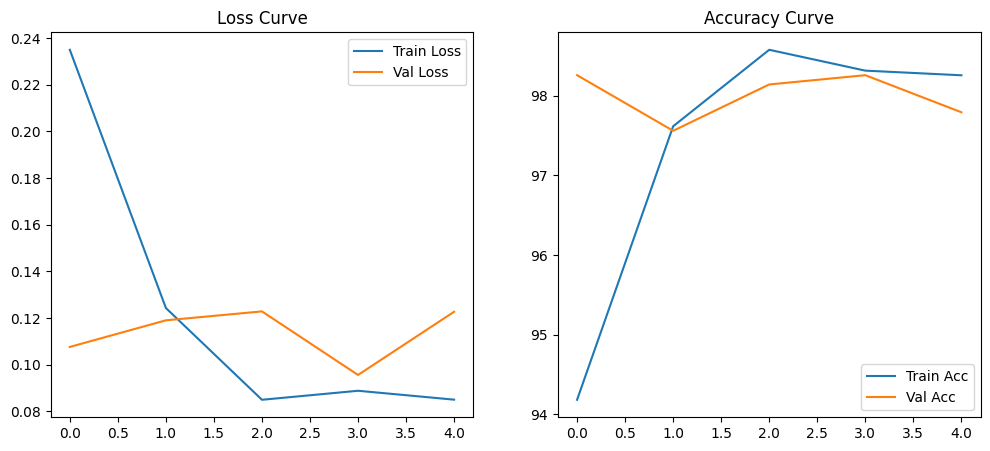

In [15]:
# Step 8: Plot Loss & Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()

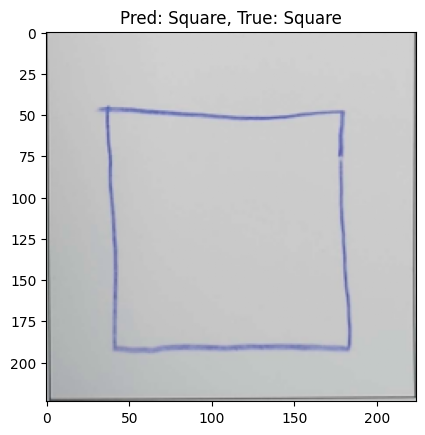

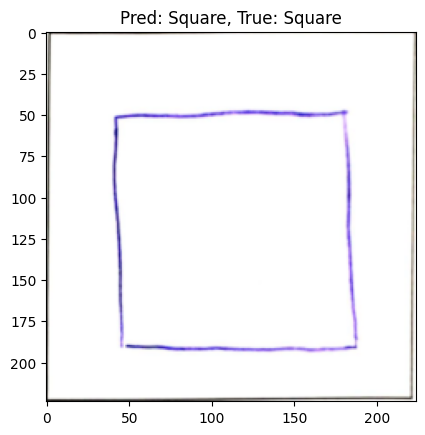

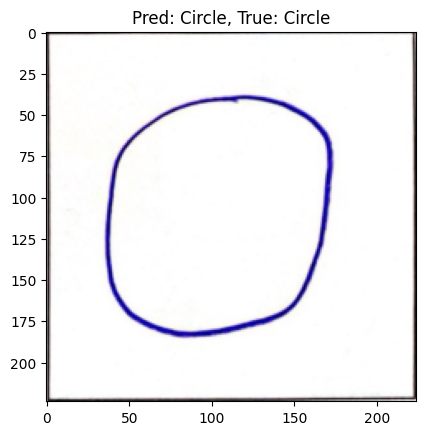

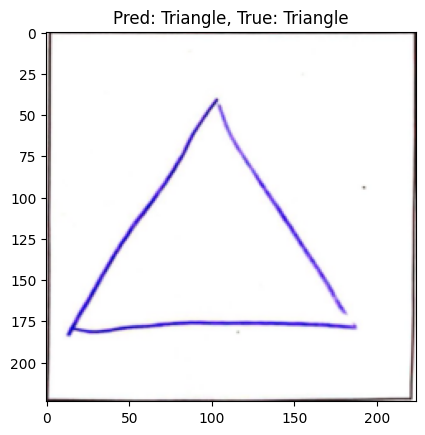

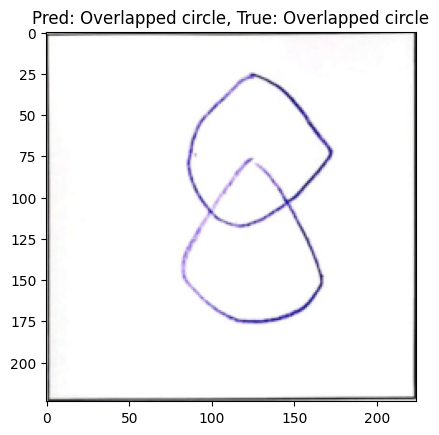

In [16]:
# Step 9: Test a few images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(DEVICE))
_, preds = torch.max(outputs, 1)

for i in range(min(5, len(images))):
    imshow(images[i], f"Pred: {class_names[preds[i]]}, True: {class_names[labels[i]]}")